In [17]:
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from pathlib import Path
import time

# Use GPU if available
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using: {device}")

Using: mps


In [18]:
# paths
DATA_PATH = Path("../data/raw/soil-classification/Orignal-Dataset")
OUTPUTS_PATH = Path("../outputs")
CHECKPOINT_PATH = OUTPUTS_PATH / "checkpoints"
CHECKPOINT_PATH.mkdir(parents=True, exist_ok=True)

# variables (ImageNet standard)
IMG_DEFAULT_SIZE = 256
IMG_CROP_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# hyperparameters
NUM_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_CLASSES = 7

RANDOM_SEED = 24

In [19]:
train_transform = transforms.Compose([
    transforms.Resize(IMG_DEFAULT_SIZE),
    transforms.RandomCrop(IMG_CROP_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

val_transform = transforms.Compose([
    transforms.Resize(IMG_DEFAULT_SIZE),
    transforms.CenterCrop(IMG_CROP_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

In [20]:
full_dataset = ImageFolder(root=DATA_PATH, transform=train_transform)

print(f"Total images: {len(full_dataset)}")
print(f"Classes: {full_dataset.classes}")

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(RANDOM_SEED)
)

# change transforms for validation and test sets
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

print(f"Training set: {len(train_dataset)}")
print(f"Validation set: {len(val_dataset)}")
print(f"Test set: {len(test_dataset)}")

Total images: 1189
Classes: ['Alluvial_Soil', 'Arid_Soil', 'Black_Soil', 'Laterite_Soil', 'Mountain_Soil', 'Red_Soil', 'Yellow_Soil']
Training set: 832
Validation set: 178
Test set: 179


In [21]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(f"Train batch size: {len(train_loader)}")
print(f"Val batch size: {len(val_loader)}")

Train batch size: 26
Val batch size: 6


In [22]:
# load pretrained model
model = models.efficientnet_b0("IMAGENET1K_V1")

for param in model.parameters():
    param.requires_grad = False

# replace classifier for 7 soil types
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)

model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("== Model used: EfficientNet-B0")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {train_params:,}")
print(f"Percentage: {100*train_params/total_params:.2f}%")


== Model used: EfficientNet-B0
Total parameters: 4,016,515
Trainable parameters: 8,967
Percentage: 0.22%


In [23]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# track training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0
start_time = time.time()

print("Training started...")
print("-" * 40)

for epoch in range(NUM_EPOCHS):
    # ========== TRAINING PHASE ==========
    model.train()
    running_loss = 0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward pass
        loss.backward()
        optimizer.step()

        # track metrics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # metrics
    train_loss = running_loss / total_train
    train_acc = 100 * correct_train / total_train
    val_loss = val_loss / val_total
    val_acc = 100 * val_correct / val_total

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    #TODO: add learning rate schedul

    # save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'class_names': full_dataset.classes
        }, CHECKPOINT_PATH/'best_model.pth')
        print(f"Epoch {epoch+1:02d}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% ** BEST **")
    else:
        print(f"Epoch {epoch+1:02d}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

elapsed = time.time() - start_time
print("-" * 40)
print(f"Training done in {elapsed/60:.1f} min")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

Training started...
----------------------------------------
Epoch 01/10 | Train Loss: 1.5055 | Train Acc: 50.36% | Val Loss: 1.2666 | Val Acc: 65.17% ** BEST **
Epoch 02/10 | Train Loss: 0.9411 | Train Acc: 75.12% | Val Loss: 0.9556 | Val Acc: 71.91% ** BEST **
Epoch 03/10 | Train Loss: 0.7467 | Train Acc: 79.69% | Val Loss: 0.8163 | Val Acc: 78.09% ** BEST **
Epoch 04/10 | Train Loss: 0.6410 | Train Acc: 82.33% | Val Loss: 0.7586 | Val Acc: 77.53%
Epoch 05/10 | Train Loss: 0.5551 | Train Acc: 83.41% | Val Loss: 0.6951 | Val Acc: 80.34% ** BEST **
Epoch 06/10 | Train Loss: 0.5039 | Train Acc: 86.42% | Val Loss: 0.6680 | Val Acc: 78.65%
Epoch 07/10 | Train Loss: 0.4668 | Train Acc: 86.66% | Val Loss: 0.6508 | Val Acc: 80.90% ** BEST **
Epoch 08/10 | Train Loss: 0.4410 | Train Acc: 87.74% | Val Loss: 0.6263 | Val Acc: 79.21%
Epoch 09/10 | Train Loss: 0.3827 | Train Acc: 89.78% | Val Loss: 0.6089 | Val Acc: 81.46% ** BEST **
Epoch 10/10 | Train Loss: 0.3980 | Train Acc: 87.62% | Val Loss

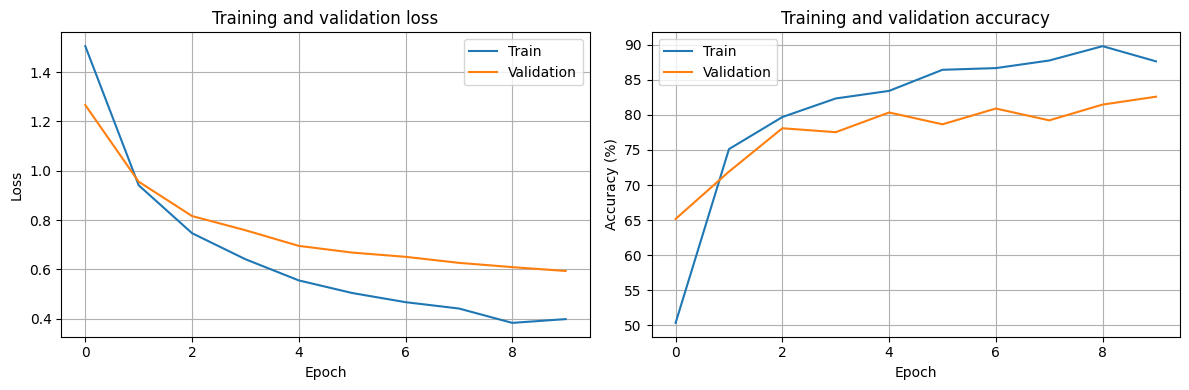

In [24]:
# plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# loss
axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and validation loss')
axes[0].legend()
axes[0].grid(True)

# accuracy
axes[1].plot(history['train_acc'], label='Train')
axes[1].plot(history['val_acc'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and validation accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(OUTPUTS_PATH/'training_curves.png')
plt.show()